# Exercise - Sensors

<div class="alert alert-block alert-success">
This is an exercise in understanding the concept of error propagation and multi-sensor systems based on Chapter 3 “Sensors”.

## Content <a id="sec_toc"> </a>

[Learning Objectives](#sec_0)

[a) Analyse Sensor Data](#sec_a)

[b) Sensor Uncertainty](#sec_b)

[c) Single-Sensor vs. Multi-Sensor System](#sec_c)


### <a id="sec_0">Learning Objectives</a>

* Understand transfer functions
* Distinguish precision from accuracy
* Apply error propagation to sensor data
* Understand the role of multi-sensor systems in classification

Import the needed libaries:

In [ ]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression

np.random.seed(42)

In [ ]:
# DO NOT CHANGE

def plot_sensor_data(true_height, ultra_measurements, pressure_measurements):
    plt.figure(figsize=(8,5))
    plt.plot(true_height, true_height, 'k--', label="True height")
    plt.plot(true_height, ultra_measurements, label="Ultrasonic sensor")
    plt.plot(true_height, pressure_measurements, label="Pressure sensor")
    plt.xlabel("True height [m]")
    plt.ylabel("Measured height [m]")
    plt.legend()
    plt.title("Sensor outputs vs. true tank height")
    plt.show()


def calc_error_metrics(true_height, ultra_measurements, pressure_measurements):
    ultra_error = ultra_measurements - true_height
    pressure_error = pressure_measurements - true_height

    print("Ultrasonic sensor:")
    print("  Accuracy (mean error):   ", round(np.mean(ultra_error), 4))
    print("  Precision (std error):   ", round(np.std(ultra_error), 4))
    print("\nPressure sensor:")
    print("  Accuracy (mean error):   ", round(np.mean(pressure_error), 4))
    print("  Precision (std error):   ", round(np.std(pressure_error), 4))

    return np.std(ultra_error), np.std(pressure_error)

def fit_transfer(true, measured):
    # Fit measured = a * true + b
    A = np.vstack([true, np.ones(len(true))]).T
    a, b = np.linalg.lstsq(A, measured, rcond=None)[0]
    return a, b

def fit_plot_transfer(true_height, ultra_measurements, pressure_measurements):
    s_ultra, o_ultra = fit_transfer(true_height, ultra_measurements)
    s_press, o_press = fit_transfer(true_height, pressure_measurements)

    print("Ultrasonic transfer function: h_meas = %.3f * h_true + %.3f" % (s_ultra, o_ultra))
    print("Pressure   transfer function: h_meas = %.3f * h_true + %.3f" % (s_press, o_press))

    plt.figure(figsize=(8,5))
    plt.scatter(true_height, ultra_measurements, s=10, label="Ultrasonic Data")
    plt.scatter(true_height, pressure_measurements, s=10, label="Pressure Data")

    plt.plot(true_height, s_ultra * true_height + o_ultra, label="Ultrasonic Fit", linewidth=2)
    plt.plot(true_height, s_press * true_height + o_press, label="Pressure Fit", linewidth=2)

    plt.xlabel("True height [m]")
    plt.ylabel("Measured height [m]")
    plt.title("Transfer Functions")
    plt.legend()
    plt.show()
    return s_ultra, o_ultra, s_press, o_press

def variance_weighting(sigma1, sigma2, ultra_measurements, pressure_measurements, true_height):
    # assumption: one sensor has constant offset
    # estimate constant bias
    b_hat = np.mean(ultra_measurements - pressure_measurements)

    # correct biased sensor
    ultra_measurements_corrected = ultra_measurements - b_hat
    # Variance weighting -> assume that the more precise is the more accurate one
    fused_height = (ultra_measurements_corrected / sigma1**2 + pressure_measurements / sigma2**2) / (1/sigma1**2 + 1/sigma2**2)

    #fused_height = (ultra_measurements / sigma1**2 + pressure_measurements / sigma2**2) / (1/sigma1**2 + 1/sigma2**2)

    plt.figure(figsize=(8, 5))
    plt.plot(true_height, true_height, 'k--', label="True height")
    plt.plot(true_height, fused_height, label="Fused estimate")
    plt.legend()
    plt.title("Multi-Sensor Fusion Result")
    plt.xlabel("True height [m]")
    plt.ylabel("Estimated height [m]")
    plt.show()

    combined_error = fused_height - true_height

    print("Combination of both sensors:")
    print("  Accuracy (mean error):   ", round(np.mean(combined_error), 4))
    print("  Precision (std error):   ", round(np.std(combined_error), 4))

def check_value(name, variable):
    if(variable == None):
        print(f"The variable {name} is still 'None'! Please adjust the variable.")
        sys.exit()

## <a id="sec_a">a) Analyse Sensor Data</a>

The objective of this exercise is to measure the water level of a water tank.\
To measure the height, two different sensors are used. \
An ultrasonic sensor measures the distance from the top of the \
tank to the water surface, while a pressure sensor measures the \
hydrostatic pressure at the bottom. Each sensor has different characteristics.

<img src="setup.png" alt="Experimental Setup" width="600">

<b>Generate sensor data</b>

<u>TASK:</u> Adjust the noise parameters of the sensors. \
Inspect how the sensor behaviour changes. 

In [ ]:
ultra_offset = None # fill in a value within the range [0, 0.1]
ultra_noise = None # fill in a value within the range [0, 0.1]
pressure_offset = None # fill in a value within the range [0, 0.1]
pressure_noise = None # fill in a value within the range [0, 0.1]

# DO NOT CHANCE
check_value("ultra_offset", ultra_offset)
check_value("ultra_noise", ultra_noise)
check_value("pressure_offset", pressure_offset)
check_value("pressure_noise", pressure_noise)

true_height = np.linspace(0.1, 2.0, 80)  
ultra_noise = np.random.normal(ultra_offset, ultra_noise, len(true_height)) 
pressure_noise = np.random.normal(pressure_offset, pressure_noise, len(true_height))

# sensor transfer functions
ultra_measurements = true_height + ultra_noise
pressure_measurements = true_height + pressure_noise

<b>Plot sensor measurements vs. true height</b>

In [ ]:
plot_sensor_data(true_height, ultra_measurements, pressure_measurements)

<b>Calculate Accuracy and Precision</b>

Within this step, we assume, that we can calculate the exact error of the sensors. \
In reality, this cannot be done, because the true measurement value is typically not known.\
Normally, accuracy is ensured by sensor calibration.

Accuracy is defined as the mean error.\
Precision is defined as the standards deviation of the error. 

In [ ]:
ultra_precision, pressure_precision = calc_error_metrics(true_height, ultra_measurements, pressure_measurements)

<b>Estimate & Plot Transfer Function</b>

Estimate sensitivity ($k$) and offset ($d$) by a linear fit

$ y_{measured} = k * y_{true} + d $

In [ ]:
k_ultra, d_ultra, k_pressure, d_pressure = fit_plot_transfer(true_height, ultra_measurements, pressure_measurements)

<b>Multi-sensor fusion</b>

To fuse the measurements of both sensors, variance weighting is applied:

$$
\hat{y} = \frac{\sum_i {y_i}/{\sigma_i^2}}{\sum_i {1}/{\sigma_i^2}}
$$


In [ ]:
variance_weighting(ultra_precision, pressure_precision, ultra_measurements, pressure_measurements, true_height)

[Back](#sec_toc)

## <a id="sec_b">b) Sensor Uncertainty</a>


In this section we look at the sensor uncertainty at a specific point. \
Therfore, we use two different approaches to calculate the uncertainty. \
First we need to calculate the delta of the operating force that is \
constructed out of different parts of the sensor uncertainties.

In [ ]:
# DO NOT CHANGE
def classical_error_propagation(dy_dk, dy_dx, dy_dd, Delta_k, Delta_x, Delta_d):
    return dy_dk * Delta_k + dy_dx * Delta_x + dy_dd * Delta_d

def gaussian_error_propagation(dydx, dydk, dydd, sigma_x, sigma_k, sigma_d):
    return np.sqrt((dydx * sigma_x)**2 + (dydk * sigma_k)**2 + (dydd * sigma_d)**2)

def estimate_true_values(ultra_measurements, pressure_measurements):
    model = LinearRegression().fit(ultra_measurements.reshape(-1,1), pressure_measurements)
    k = model.coef_[0]
    d = model.intercept_
    return k, d

def estimate_sensor_noise(ultra_measurements):
    # estimate noise in ultrasonic sensor
    # -> estimate the noise in ultrasonic sensor = sample std of residuals after smoothing
    # Fit a line to the ultrasonic data
    model_ultra = LinearRegression().fit(
        np.arange(len(ultra_measurements)).reshape(-1, 1),
        ultra_measurements
    )
    # Predicted signal (smooth)
    ultra_pred = model_ultra.predict(np.arange(len(ultra_measurements)).reshape(-1, 1))
    # Residuals = estimated noise
    ultra_residuals = ultra_measurements - ultra_pred
    sigma_ultrasonic = np.std(ultra_residuals)
    return sigma_ultrasonic

In the code cell below, we estimate the uncertainty of the sensor-to-sensor regression model \
 as a function of ultrasonic measurement). \
This includes uncertainties from both sensors:
* the ultrasonic sensor (which provides noisy x-values), and
* the pressure sensor (whose noise appears in the regression residuals and affects the fitted slope $k$ and offset $d$.

Therefore, the uncertainty we propagate reflects the combined effect of both sensors on the estimated pressure.

In [ ]:
# estimate sensor model by estimating the following values:
# * true values
# * noise
k, d = estimate_true_values(ultra_measurements, pressure_measurements)
sigma_ultrasonic = estimate_sensor_noise(ultra_measurements)

### Classical Error Propagation


Within the next code snipped the classical error propagation is used for the linear function of the ideal sensor.
$$\Delta_y = \frac{\delta_y}{\delta_k} * \Delta_k + \frac{\delta_y}{\delta_x} * \Delta_x + \frac{\delta_y}{\delta_d} * \Delta_d $$

Since we model our sensor as:

$$ y = k*x + d $$

$$ \frac{\delta_y}{\delta_k} = x, \frac{\delta_y}{\delta_x} = k, \frac{\delta_y}{\delta_d} = 1 $$

First, the needed parameters are defined:

In [ ]:
# DO NOT CHANGE
# define parameters
delta_k = 0.01 # uncertainty in k
delta_d = 0.005 # uncertainty in offset
delta_x = sigma_ultrasonic

dydk = ultra_measurements
dydx = k
dydd = 1

Apply classical error propagation:

In [ ]:
# DO NOT CHANGE
delta_y_classical = classical_error_propagation(dydk, dydx, dydd, delta_k, delta_x, delta_d)
print("Result of the classical error porpagation: ", delta_y_classical[:5])

### Gaussian Error Propagation


Within the next code snipped the gaussian error propagation is used for the linear function of the ideal sensor. \
The law is used to calculate the upperbound of the standard deviation of the sensor uncertainty. \
We assume that the measurement errors follow a Gaussian distribution.

$$\sigma_y^2 = \sigma_x^2 + \sigma_k^2 + \sigma_d^2 $$

$$\sigma_y^2 = (\frac{\delta_y}{\delta_x})^2 \sigma_x^2 + (\frac{\delta_y}{\delta_k})^2 \sigma_k^2 + (\frac{\delta_y}{\delta_d})^2 \sigma_d^2 $$

In [ ]:
# DO NOT CHANGE
# define sigmas
sigma_x = sigma_ultrasonic
sigma_k = delta_k
sigma_d = delta_d

# calculate gaussian error propagation
sigma_y = gaussian_error_propagation(dydx, dydk, dydd, sigma_x, sigma_k, sigma_d)
print("Result of the gaussian error porpagation: ", sigma_y[:5])

[Back](#sec_toc)

## <a id="sec_c">c) Single-Sensor vs. Multi-Sensor System</a>

In this chapter, we are using a double sensor system to predict whether it will rain or not. \
This means that our model typically relies on two types of input data to make predictions:
* Temperature 
* Humidity

We will have a look at our data in a scatter plot and we will also try to make predictions with either only temperature or humidity.

In [5]:
# DO NOT CHANGE

def generate_weather_data(mean_temp_no_rain, std_temp_no_rain, mean_humid_no_rain, std_humid_no_rain,
                          mean_temp_rain, std_temp_rain, mean_humid_rain, std_humid_rain,
                          n_samples=1000, flip_prob=0.00, random_seed=None):
    """
    Generate weather data with specified means and standard deviations for temperature and humidity.

    Parameters:
    mean_temp_no_rain, std_temp_no_rain: Mean and std for temperature when no rain.
    mean_humid_no_rain, std_humid_no_rain: Mean and std for humidity when no rain.
    mean_temp_rain, std_temp_rain: Mean and std for temperature when rain.
    mean_humid_rain, std_humid_rain: Mean and std for humidity when rain.
    n_samples: Total number of samples to generate (split equally between rain and no rain).
    flip_prob: Probability of flipping the label (to introduce noise).
    random_seed: int, optional. Random seed for reproducibility (default: None).

    Returns:
    pd.DataFrame: DataFrame with columns ['temperature', 'humidity', 'label'].
    """
    if random_seed is not None:
        np.random.seed(random_seed)

    n_no_rain = n_samples // 2
    n_rain = n_samples - n_no_rain

    # Generate data for no rain
    temp_no_rain = np.random.normal(mean_temp_no_rain, std_temp_no_rain, n_no_rain)
    humid_no_rain = np.random.normal(mean_humid_no_rain, std_humid_no_rain, n_no_rain)
    labels_no_rain = np.zeros(n_no_rain)

    # Generate data for rain
    temp_rain = np.random.normal(mean_temp_rain, std_temp_rain, n_rain)
    humid_rain = np.random.normal(mean_humid_rain, std_humid_rain, n_rain)
    labels_rain = np.ones(n_rain)

    # Combine the data
    temp = np.concatenate([temp_no_rain, temp_rain])
    humid = np.concatenate([humid_no_rain, humid_rain])
    labels = np.concatenate([labels_no_rain, labels_rain])

    # Flip labels with the specified probability
    flip_indices = np.random.rand(n_samples) < flip_prob
    labels[flip_indices] = 1 - labels[flip_indices]

    # Create a DataFrame
    data = pd.DataFrame({
        'temperature': temp,
        'humidity': humid,
        'label': labels
    })

    return data

def plot_weather_data(data):
    """
    Plot the weather data as a scatter plot.

    Parameters:
    data: pd.DataFrame with columns ['temperature', 'humidity', 'label'].
    """
    colors = ['orange', 'blue']
    labels = ['No Rain', 'Rain']

    plt.figure()

    for label, color, label_name in zip([0, 1], colors, labels):
        subset = data[data['label'] == label]
        plt.scatter(subset['humidity'], subset['temperature'], label=label_name, alpha=0.6, c=color)

    plt.xlabel('Humidity (%)')
    plt.ylabel('Temperature (°C)')
    plt.title('Weather Data (Rain vs No Rain)')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

def train_and_predict(data, features=None, random_seed=42):
    """
    Trains and evaluates a binary classification model using specified features (or all by default),
    and plots predictions.

    Parameters:
    data: pd.DataFrame with feature columns and a 'label' column.
    features: list, optional. The features to use for training (default: all columns except 'label').
    random_seed: int, optional. Random seed for reproducibility (default: 42).

    Returns:
    None
    """
    # If no specific features are provided, use all columns except 'label'
    if features is None:
        features = [col for col in data.columns if col != 'label']

    # Ensure the features exist in the dataset
    for feature in features:
        if feature not in data.columns:
            raise ValueError(f"Feature '{feature}' not found in the data.")

    # Define X (features) and y (label)
    X = data[features]
    y = data['label']

    # Perform an 80-20 train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.32423, random_state=random_seed)

    # Train a Random Forest Classifier
    model = RandomForestClassifier(random_state=random_seed)
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    feature_desc = ", ".join(features)

    # If only one feature is used, reconstruct missing features for plotting
    if len(features) == 1:
        missing_feature = 'temperature' if features[0] == 'humidity' else 'humidity'
        X_test[missing_feature] = data.loc[X_test.index, missing_feature]

    # Plot predictions with a detailed title including accuracy
    title = f"Predictions Using Features: {feature_desc} (Accuracy: {accuracy:.4f})"
    plot_predictions(data, X_test, y_test, y_pred, title=title)

def plot_predictions(data, X_test, y_test, y_pred, title="Prediction Results"):
    """
    Plot predictions with temperature on the y-axis and humidity on the x-axis.
    Correct predictions are shown with dots, and incorrect ones with crosses.

    Parameters:
    data: Original DataFrame with ['temperature', 'humidity', 'label'].
    X_test: Test features (DataFrame).
    y_test: True labels for the test data.
    y_pred: Predicted labels for the test data.
    title: Custom title for the plot.

    Returns:
    None
    """
    colors = ['orange', 'blue']
    labels = ['No Rain', 'Rain']

    # Convert y_test and y_pred to numpy arrays for compatibility
    y_test = np.array(y_test)
    y_pred = np.array(y_pred)

    # Ensure indices of X_test align with the boolean masks
    X_test = X_test.reset_index(drop=True)

    plt.figure(figsize=(8, 6))

    for label, color, label_name in zip([0, 1], colors, labels):
        # Filter correct predictions
        correct = (y_test == label) & (y_test == y_pred)
        plt.scatter(
            X_test.loc[correct, 'humidity'],  # Humidity on x-axis
            X_test.loc[correct, 'temperature'],  # Temperature on y-axis
            label=f"Correct {label_name}", c=color, alpha=0.6, marker='o'
        )

        # Filter incorrect predictions
        incorrect = (y_test == label) & (y_test != y_pred)
        plt.scatter(
            X_test.loc[incorrect, 'humidity'],  # Humidity on x-axis
            X_test.loc[incorrect, 'temperature'],  # Temperature on y-axis
            label=f"Incorrect {label_name}", c=color, alpha=0.6, marker='x'
        )

    plt.xlabel('Humidity (%)')
    plt.ylabel('Temperature (°C)')
    plt.title(title)
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

In the code snipped below you can determine how the data distribution will look like by asserting values to the variables \
which determine the mean and standard deviation of the data. The type of distribution is a gaussian normal distribution.

<u>TASK:</u> Change the values below to determine how the data distribution will look like.

In [6]:
# Change the values (means and standard deviations) below to determine how the data distribution will look like
# Temperature in Degree Celsius [0, 70]     (Example: mean_temp_no_rain = 23.8)
# Humidity in % [0, 100]                    (Example: mean_humid_no_rain = 50)
mean_temp_no_rain = 3
std_temp_no_rain = 3
mean_humid_no_rain = 3
std_humid_no_rain = 3
mean_temp_rain = 3
std_temp_rain = 3
mean_humid_rain = 3
std_humid_rain = 3

# DO NOT CHANGE THE CODE UNDERNEATH
check_value("mean_temp_no_rain", mean_temp_no_rain)
check_value("std_temp_no_rain", std_temp_no_rain)
check_value("mean_humid_no_rain", mean_humid_no_rain)
check_value("std_humid_no_rain", std_humid_no_rain)
check_value("mean_temp_rain", mean_temp_rain)
check_value("std_temp_rain", std_temp_rain)
check_value("mean_humid_rain", mean_humid_rain)
check_value("std_humid_rain", std_humid_rain)

Use the generated data:

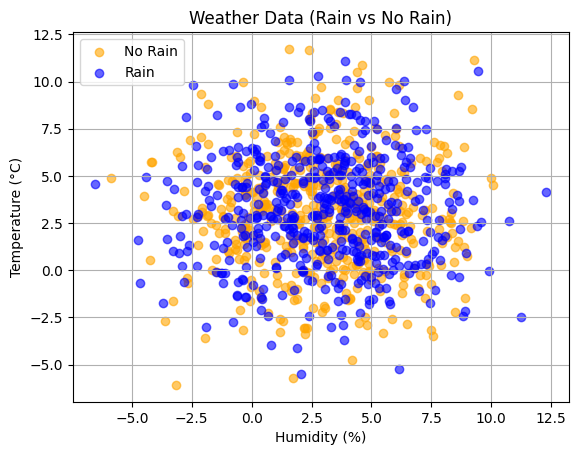

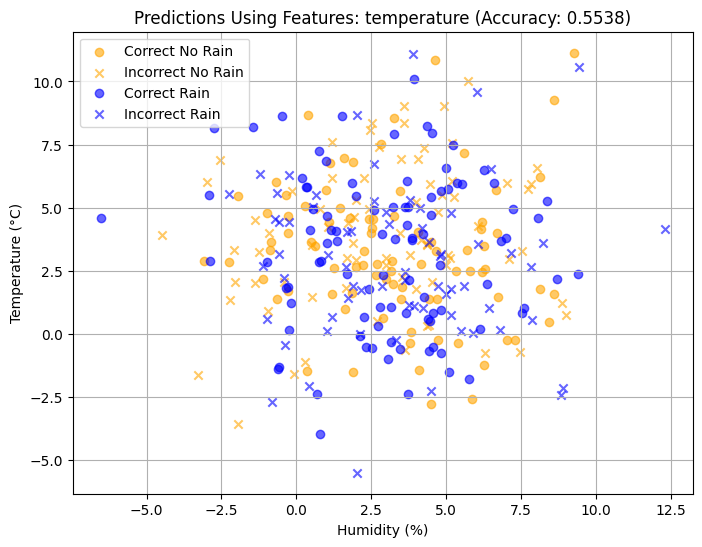

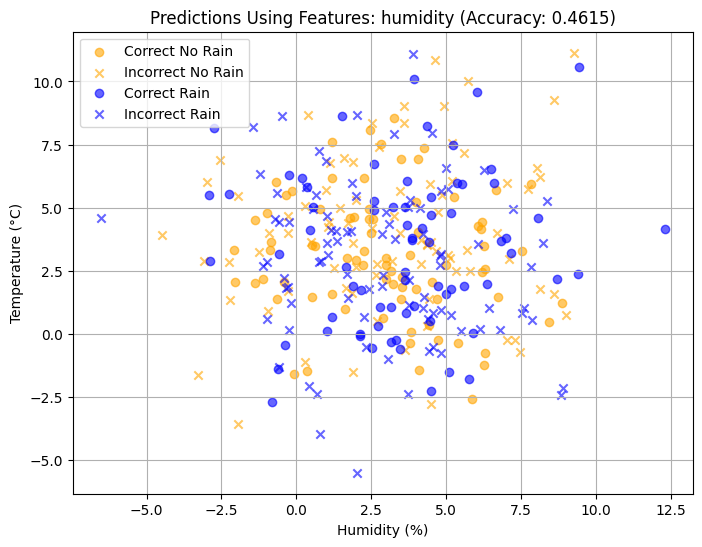

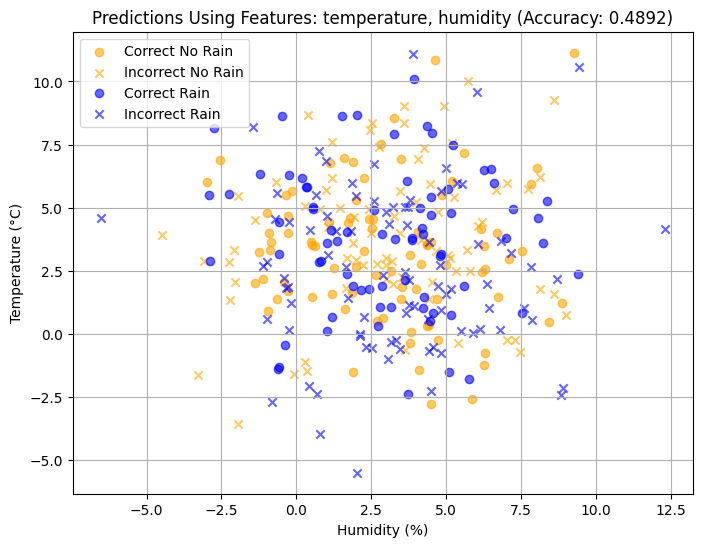

In [7]:
data_graz = generate_weather_data(mean_temp_no_rain=mean_temp_no_rain, std_temp_no_rain=std_temp_no_rain,
                             mean_humid_no_rain=mean_humid_no_rain, std_humid_no_rain=std_humid_no_rain,
                             mean_temp_rain=mean_temp_rain, std_temp_rain=std_temp_rain,
                             mean_humid_rain=mean_humid_rain, std_humid_rain=std_humid_rain,
                             n_samples=1000, random_seed=43)
plot_weather_data(data_graz)

# Train and predict using only temperature
train_and_predict(data_graz, features=['temperature'], random_seed=42)

# Train and predict using only humidity
train_and_predict(data_graz, features=['humidity'], random_seed=42)

# Train and predict using all features
train_and_predict(data_graz, random_seed=42)

[Back](#sec_toc)